### Modified Box-Counting Algorithm

In this notebook I modify the box-counting algorithm in such a way, to estimate the fractal dimension.
Here, the smallest box size, $s_{min}$ is defined to be comparable with a typical building size.

In [59]:
# Import some stuff first
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
#from code.plot_utils import plot_pretty
from matplotlib import rcParams
from skimage.color import rgb2gray
import pylab as pl
rcParams['font.family'] = 'serif'
%matplotlib inline
%pylab inline

#plot_pretty()

Populating the interactive namespace from numpy and matplotlib


In [60]:
def box_counts(x,y, n_bins, hist_range):
    """
    This function uses the 2-dimensional histogram to count the number of bins 
    that contain at least one non-zero element.
    ------------------------------------------
    Inputs:
    x, y: One dimensional-arrays. They contain the positions (i,j) where there is
    a pixel of the matrix X (see next function) that contains "something" (buiding, street etc)
    n_bins : Number of bins in each dimension. Since the input matrix is square, the number of bins
    is the same in both dimensions.
    hist_range: [[x_min, y_max], [y_min, y_max]]. The maximum and minimum limits of the bins. In practice
    this is always [0, len(X)].
    ------------------------------------------
    Returns:
    Number of boxes with non-zero counts
    """
    # Get a 2-d histogram of the points x,y
    Hist, xedg, yedg = np.histogram2d(x,y, bins=n_bins, range=hist_range, density=False)
        
    # Get the number of bins that contain at least one point
    counts = np.sum(Hist>0)
    
    return counts

In [61]:
def fractal_dimension(X, threshold, p_min):
    """
    Calculates the fractal dimension of an image in grayscale
    ---------------------------
    Inputs:
    X: 2-Dimensional matrix. Each value is a pixel with values 0-1. 
    threshold: When X[i,j] < threshold, assume that "something" is there (building, street etc)
    p_min : Integer, such as the minimum box size used is 2^{p_min}
    ---------------------------
    Returns:
    Frac_dim: the estimated fractal dimension
    size, counts: arrays of size p+1 that contain the boxes sizes and the number of counts 
    needed to cover the "fractal" per size. That is good if we want to plot and inspect
    """
    
    # Get the maximum dimension of the 2-d array X
    M_dim = max(X.shape)
    
    # Get p. p is the smallest integer such that max(size(X)) <= 2P.
    p = np.ceil((np.log(M_dim)/np.log(2.0)))
    
    # The integer version of it now
    int_p = int(p) 
    
    assert (int_p > p_min), "p_min is larger or equal to the maximum p"
    
    
    print("Maximum power of 2 used:", int_p)
    # =========================================
    # Number of rows and  columns of the input matrix X
    rows = len(X[:,0])
    cols = len(X[0,:])
    
    # ========================================
    # Now create a padded square matrix, with size 2^p in each dimension
    len_X = int(2.0**int_p) # Its length in each dimension
    
    #Initialize it with ones everywhere
    X_padded = np.ones([len_X,len_X])
    
    # Now substitute in it the elements of the input matrix X.
    # Matrix X has smaller (or equal) dimensions than X_padded
    for i in range(rows):
        for j in range(cols):
            X_padded[i,j] = X[i,j]
            
    # =========================================
    # Now find the position of pixels of X_padded with value < threshold
    x_s = [] #Empty list for the i positions
    y_s = [] #Empty list for the j positions
    
    for i in range(len_X):
        for j in range(len_X):
            if (X_padded[i,j]<threshold):
                x_s.append(i)
                y_s.append(j)
                
    # Transform the lists to arrays
    x_arr = np.asarray(x_s)
    y_arr = np.asarray(y_s)
    
    # Just to see that everything looks ok, let's plot here
    # We can comment out this in later implementations, not necessary
    pl.plot(y_arr, x_arr, '.', ms=0.02)
    pl.show()
    
    # =========================================
    # Now an array of exponents, from p to 0
    #exponents = np.arange(int_p,-1, -1)   # Note: here I can possibly change the minimum box size, instead of zero
    exponents = np.arange(int_p,p_min-1, -1)
    # Box sizes, 2^i, i = [p, ..., 0]. So in pixels 2^p, ....., 1
    sizes = 2.0**exponents 
    
    # =========================================
    # =========================================
    
    # Here perform the box counting using the 2-d histogram function
    
    # Limits of the histogram in all cases 
    hist_ranges = [[0,len_X], [0, len_X]]
    
    # Number of bins for each bin size s:
    n_bins = 2**(int_p - exponents)
    

    
    length = len(exponents) # the length of the arrays
    
  
    # Initialize an array of counts 
    counts = np.zeros(length)
    
    #Now populate the counts array - run a for loop in all box sizes
    for i in range(length):
        num_bin = int(n_bins[i]) #Number of bins - make it integer
        
        print("Runs for bin size:", sizes[i])
        
        counts[i] = box_counts(x_arr,y_arr, num_bin, hist_ranges)
    
    # Now perform a linear fit
    coeffs= np.polyfit(np.log10(sizes), np.log10(counts), 1)
    # Fractal dimension = - the slope
    Frac_dim = - coeffs[0]
    
    print ("The estimated  fractal dimension is:", Frac_dim)
    
    return Frac_dim, sizes, counts

In [62]:
def min_p_ret(dist, dpi, siz_fig, build_size):
    
    pix_in_m = 2.0*dist/(dpi*siz_fig)
    
    size_in_pix = build_size/pix_in_m
    
    min_p = np.ceil((np.log(size_in_pix)/np.log(2.0)))
    
    return int(min_p)
    

In [63]:
#dist = 1000
#dpi = 1000
#sig_fig = 10.0
#build_size = 5.0

#min_p = min_p_ret(dist, dpi, sig_fig, build_size)
min_p = 1

In [64]:
# Read and convert to gray scale 
I = rgb2gray(pl.imread("brit.png"))

('Maximum power of 2 used:', 11)


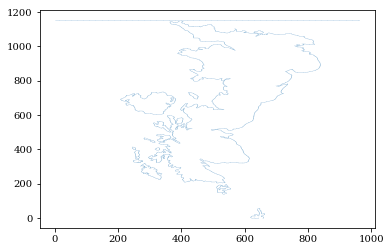

('Runs for bin size:', 2048.0)
('Runs for bin size:', 1024.0)
('Runs for bin size:', 512.0)
('Runs for bin size:', 256.0)
('Runs for bin size:', 128.0)
('Runs for bin size:', 64.0)
('Runs for bin size:', 32.0)
('Runs for bin size:', 16.0)
('Runs for bin size:', 8.0)
('Runs for bin size:', 4.0)
('Runs for bin size:', 2.0)
('The estimated  fractal dimension is:', 1.3057067556310276)


In [65]:
# Calculate the fractal dimension 
FD, siz, counts = fractal_dimension(I, 0.5,min_p)

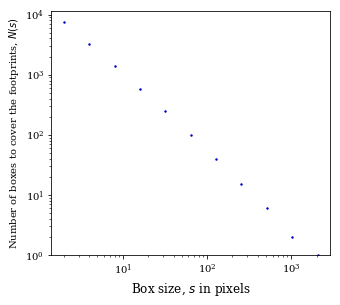

In [66]:
fig = plt.figure(figsize = (5.0,4.5))

plt.scatter(siz, counts, s= 2.0, color='mediumblue')
plt.xscale('log');plt.yscale('log')

plt.xlabel('Box size, $s$ in pixels', fontsize=12)
plt.ylabel('Number of boxes to cover the footprints, $N(s)$')

plt.ylim(1,)

plt.show()